<a href="https://colab.research.google.com/github/liuchentue/SVM-based-human-detection/blob/main/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install dependencies: 
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 25kB/s 
     |████████████████████████████████| 6.6MB 2.7MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 276kB 8.1MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=37b836061ca10c843678af84b0532c0619753bf5e368b067292f54bd28947278
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-

In [2]:
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2

# get image
!wget http://images.cocodataset.org/val2017/000000439715.jpg -O input.jpg
im = cv2.imread("./input.jpg")

# Create config
cfg = get_cfg()
cfg.merge_from_file("/usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl"

# Create predictor
predictor = DefaultPredictor(cfg)

# Make prediction
outputs = predictor(im)

--2020-12-04 04:39:09--  http://images.cocodataset.org/val2017/000000439715.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.32.24
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.32.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209222 (204K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>] 204.32K  1.06MB/s    in 0.2s    

2020-12-04 04:39:09 (1.06 MB/s) - ‘input.jpg’ saved [209222/209222]



model_final_f6e8b1.pkl: 243MB [00:02, 86.3MB/s]                           


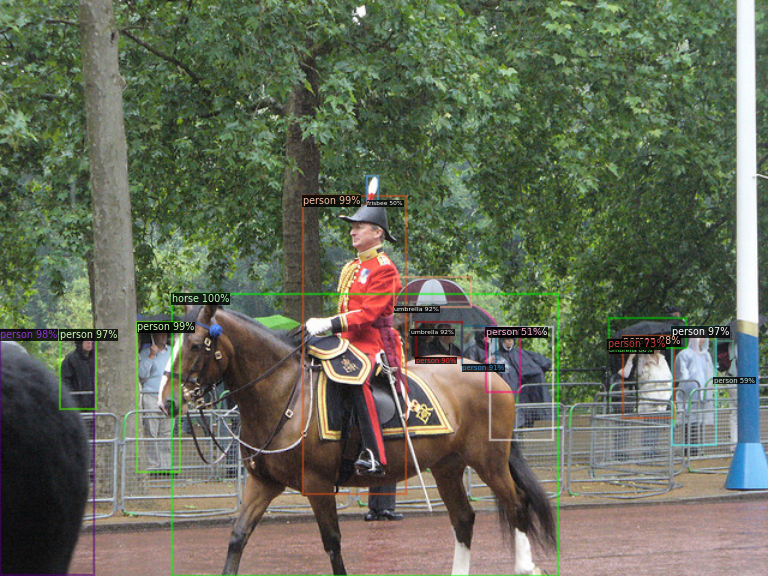

In [19]:
from google.colab.patches import cv2_imshow
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])


In [74]:
import numpy as np
import tensorflow as tf

inst=outputs["instances"]


classes=inst.get("pred_classes")
precision=inst.get("scores")
locations=inst.get("pred_boxes")

classes=tf.make_ndarray(tf.make_tensor_proto(classes.cpu())) 
precision=tf.make_ndarray(tf.make_tensor_proto(precision.cpu())) 
locations=tf.make_ndarray(tf.make_tensor_proto(locations.tensor.cpu())) 

print(classes)
print(precision)
print(locations)

#classes: what type of object is detected (for example, 0 for person; 25 for umbrella; 17 for horse) (based on COCO dataset)
#locations: the boxes locations of the detected objects (in our case, there are 17 boxes in the example photo)
#precision: the probability of the corresponding object classification to be accurate
numofperson=0
for i in range(len(classes)):
  if (classes[i]==0):
    numofperson=numofperson+1
print("Number of people in the picture:",numofperson)

personboxes=[]

[17  0  0  0  0  0  0 25 25  0  0  0 25  0  0  0 29]
[0.99948835 0.99253684 0.9900002  0.98492014 0.97837126 0.97332925
 0.9710518  0.92249656 0.9204272  0.91499597 0.90140533 0.8770402
 0.862336   0.72565615 0.58743477 0.5068365  0.5017522 ]
[[1.43240860e+02 2.45390594e+02 4.64953583e+02 4.79869110e+02]
 [1.14412537e+02 2.69079865e+02 1.49621262e+02 3.93161652e+02]
 [2.52468430e+02 1.63972412e+02 3.38196381e+02 4.12057861e+02]
 [1.06968835e-01 2.75446442e+02 7.84416046e+01 4.78835968e+02]
 [5.19292725e+02 2.80650970e+02 5.61258484e+02 3.48397247e+02]
 [5.60055481e+02 2.72977020e+02 5.96374146e+02 3.70651978e+02]
 [4.98307877e+01 2.75448914e+02 7.95948868e+01 3.41225525e+02]
 [3.42556854e+02 2.51854752e+02 4.16229034e+02 2.75427856e+02]
 [3.28632538e+02 2.31069351e+02 3.92328430e+02 2.56467285e+02]
 [3.85285706e+02 2.72190948e+02 4.13522675e+02 3.04711090e+02]
 [3.46307251e+02 2.68994232e+02 3.85014648e+02 2.98491425e+02]
 [4.07968323e+02 2.73188904e+02 4.60711548e+02 3.66982269e+02]
 

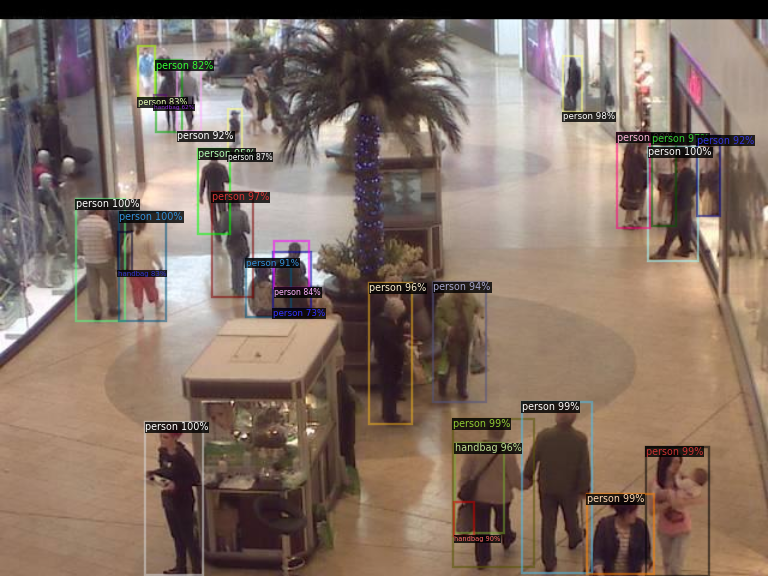

In [ ]:
img0001 = cv2.imread("/seq_000001.jpg")



# Make prediction
outputs = predictor(img0001)

v = Visualizer(img0001[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])